In [108]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy import integrate
import cgs as cgs
from scipy import interpolate

In [109]:
fpath = '/home/emerick/Research/dwarfs/flash_runs/carina_final/'

mass_adiabatic = np.genfromtxt(fpath + "../carina_adiabatic/mass_evolution_0-300.dat",names=True)


In [110]:
def solvr(x,t,A):
    return [x[1],A/x[0]]

In [111]:
rho_i = 1.0 * cgs.mp * 1.31
rho_h = 1.0E-4 * cgs.mp * 0.62
v = 200.0E5
r_o = 400.*cgs.pc

A = rho_h * v*v * 0.5 / rho_i

In [112]:
t = np.linspace(0.0,500.0,1000.0)*cgs.Myr
r = integrate.odeint(solvr, [r_o,0], t, args=(A,))

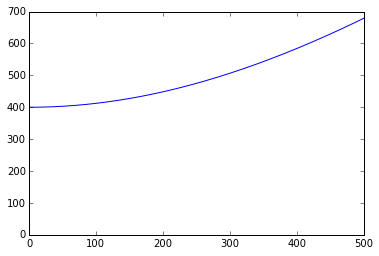

In [113]:
plt.plot(t/cgs.Myr,r/cgs.pc)

In [114]:
from initial_conditions import ic_list as icl

In [115]:
carina = icl.ic_object_dict['CarinaMidMed']

In [130]:
### now for something entirely different ###

def f(y, t, rho_halo, v, rho_gas):
    # y contains mass as y[0] and radius as y[1]
    Mi = y[0]
    Ri = y[1]
    
    
    num = 1.0
    if Mi <= 0 or Ri <=0:
        Ri = 0.0
        num = 0.0
    #else: 
    #rdot = -0.5 * (4.0/3.0)*(rho_halo/rho_gas(Ri))**0.5 * v
    c_sound = ((5.0/3.0)*cgs.kb*1.0E4/(cgs.mp*1.31))**0.5
    rdot = -c_sound
    
    mdot = 4.0*np.pi*Ri**2 * rho_gas(Ri) * rdot
  

    
    return [num*mdot, num*rdot]
    
def KH(y, t, rho_halo, v, rho_gas):
    Mi = y[0]
    Ri = y[1]
    
    Mdot = -np.pi * Ri**2 * rho_halo * v
    Rdot = Mdot / (4.0*np.pi*Ri**2 * rho_gas(Ri))
    
    return [Mdot,Rdot]

def KH_t(y, t, rho_halo, v, rho_gas):
    Mi = y[0]
    Ri = y[1]
    
    Mdot = -np.pi * Ri**2 * rho_halo(t) * v(t)
    Rdot = Mdot / (4.0*np.pi*Ri**2 * rho_gas(Ri))
    
    return [Mdot,Rdot]

In [137]:
print carina.ic.keys()
print carina.ic['RM'] / cgs.pc
print (carina.ic['RM']/((5.0/3.0)*cgs.kb*1.0E4/(cgs.mp*1.31))**0.5)/cgs.Myr
c_sound = ((5.0/3.0)*cgs.kb*1.0E4/(cgs.mp*1.31))**0.5
print c_sound / 1.0E5

['r_s', 'T_dwarf', 'b', 'mu_halo', 'RM', 'M200', 'n_halo', 'potential_type', 'M_DM', 'mu_dwarf', 'n_o', 'r_DM', 'c', 'T_halo', 'rho_crit']
423.12007563
40.3727153889
10.2478293046


In [132]:
rho_halo = carina.ic['n_halo'] * cgs.mp * carina.ic['mu_halo']
v = 200.0E5
R_o = carina.ic['RM']
M_o = 6.6E5 * cgs.Msun # approx

t = np.linspace(0.0,120.0,100.0)*cgs.Myr

soln = integrate.odeint(f, [M_o,R_o],t, args=(rho_halo, v, carina.find_density_profile,))


In [133]:
M = soln[:,0]; R = soln[:,1]
select = M > 0
M = M[select]; t = t[select]; R = R[select]

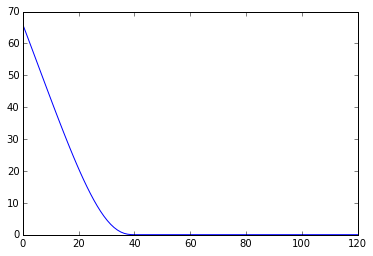

In [134]:
plt.plot(t/cgs.Myr, M/(1.0E4*cgs.Msun))

(0, 500)

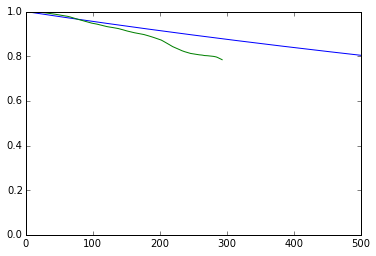

In [123]:
rho_halo = carina.ic['n_halo'] * cgs.mp * carina.ic['mu_halo']
v = 200.0E5
R_o = carina.ic['RM']
M_o = 6.6E5 * cgs.Msun # approx

t = np.linspace(0.0,1200.0,1000.0)*cgs.Myr

soln = integrate.odeint(KH, [M_o,R_o],t, args=(rho_halo, v, carina.find_density_profile,))
M_KH = soln[:,0]; R_KH = soln[:,1]
plt.plot(t/cgs.Myr,M_KH/(M_KH[0]))
plt.plot(mass_adiabatic['t'], mass_adiabatic['m']/mass_adiabatic['m'][0])
plt.ylim(0,1)
plt.xlim(0,500)

In [124]:
carina_orbit = np.genfromtxt("./../orbits/carina_orbit_tab.dat")
t_orbit = carina_orbit[:,0] * cgs.Myr
v_orbit = carina_orbit[:,2] * 1.0E5


(0, 500)

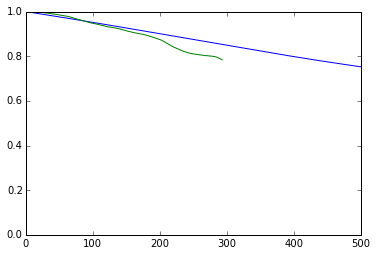

In [129]:

def rho_halo_func(t):
    rho_halo = carina.ic['n_halo'] * cgs.mp * carina.ic['mu_halo']
    return rho_halo # constant density

velocity_func = interpolate.UnivariateSpline(t_orbit, v_orbit,k=3)     # cubic spline 

R_o = carina.ic['RM']
M_o = 6.6E5 * cgs.Msun # approx

t = np.linspace(0.0,1200.0,1000.0)*cgs.Myr

soln = integrate.odeint(KH_t, [M_o,R_o],t, args=(rho_halo_func, velocity_func, carina.find_density_profile,))
M_KH = soln[:,0]; R_KH = soln[:,1]
plt.plot(t/cgs.Myr,M_KH/(M_KH[0]))
plt.plot(mass_adiabatic['t'], mass_adiabatic['m']/mass_adiabatic['m'][0])
plt.ylim(0,1)
plt.xlim(0,500)

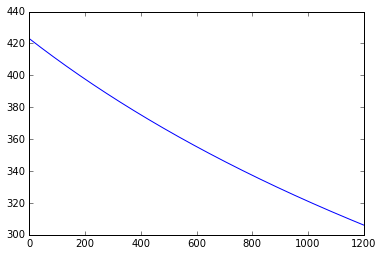

In [96]:
plt.plot(t/cgs.Myr, R_KH/cgs.pc)

In [97]:
r  = np.linspace(1.0*cgs.pc,R_o,1000)
rho_gas = carina.find_density_profile(r)
rho_DM  = carina.DM_density(r)
integrand = lambda x: x*x*carina.DM_density(x)
gas = lambda x: x*x*carina.find_density_profile(x)
M_DM = np.zeros(np.size(r)-1)
M_gas = np.zeros(np.size(r)-1)
for i in np.arange(1,np.size(r)):
    M_DM[i-1] = 4.0*np.pi* integrate.quad(integrand, 0.0, r[i])[0]
    M_gas[i-1] = 4.0*np.pi* integrate.quad(gas, 0.0,r[i])[0]

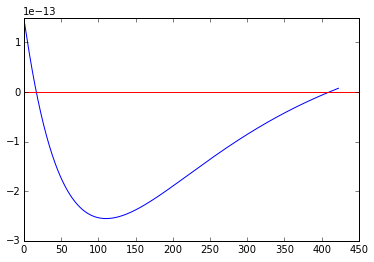

In [53]:
rho_halo = carina.ic['n_halo'] * cgs.mp * carina.ic['mu_halo']
v = 300.0E5
RHS = (M_DM + M_gas) * rho_gas[:-1] / r[:-1] * cgs.G * np.pi * 0.5
LHS = rho_halo * v*v
RPS = LHS - RHS
plt.plot(r[:-1]/cgs.pc,RPS)
plt.plot(plt.xlim(),[0,0],color='red')

In [38]:
print LHS
print RHS

7.05176592e-14
[  2.15664185e-14   2.53941171e-14   2.94450052e-14   3.35731565e-14
   3.77244987e-14   4.18744671e-14   4.60103699e-14   5.01250489e-14
   5.42142099e-14   5.82751622e-14   6.23061691e-14   6.63060909e-14
   7.02741762e-14   7.42099351e-14   7.81130587e-14   8.19833665e-14
   8.58207712e-14   8.96252538e-14   9.33968468e-14   9.71356215e-14
   1.00841679e-13   1.04515144e-13   1.08156158e-13   1.11764878e-13
   1.15341472e-13   1.18886116e-13   1.22398994e-13   1.25880294e-13
   1.29330210e-13   1.32748939e-13   1.36136680e-13   1.39493635e-13
   1.42820007e-13   1.46116000e-13   1.49381818e-13   1.52617668e-13
   1.55823755e-13   1.59000283e-13   1.62147459e-13   1.65265488e-13
   1.68354573e-13   1.71414920e-13   1.74446730e-13   1.77450208e-13
   1.80425553e-13   1.83372968e-13   1.86292652e-13   1.89184805e-13
   1.92049623e-13   1.94887304e-13   1.97698044e-13   2.00482038e-13
   2.03239480e-13   2.05970561e-13   2.08675474e-13   2.11354409e-13
   2.14007555e-13  